In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG, img_to_array, array_to_img
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as pi
from tensorflow.keras.optimizers import RMSprop
from shutil import copy
import time

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
path = '../input/celeba-dataset/img_align_celeba/img_align_celeba'
pathBbox = '../input/celeba-dataset/list_bbox_celeba.csv'
pathLmark = '../input/celeba-dataset/list_landmarks_align_celeba.csv'

In [4]:
Bbox = pd.read_csv(pathBbox)
Lmark = pd.read_csv(pathLmark)
df = pd.read_csv('../input/celeba-dataset/list_attr_celeba.csv')
print(f'No. of images: {len(os.listdir(path))}')
print(f'Shape of Bbox: {Bbox.shape}')
print(f'Shape of Bbox: {Lmark.shape}')

No. of images: 202599
Shape of Bbox: (202599, 5)
Shape of Bbox: (202599, 11)


In [5]:
Bbox.head()

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


In [6]:
Lmark.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


In [7]:
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


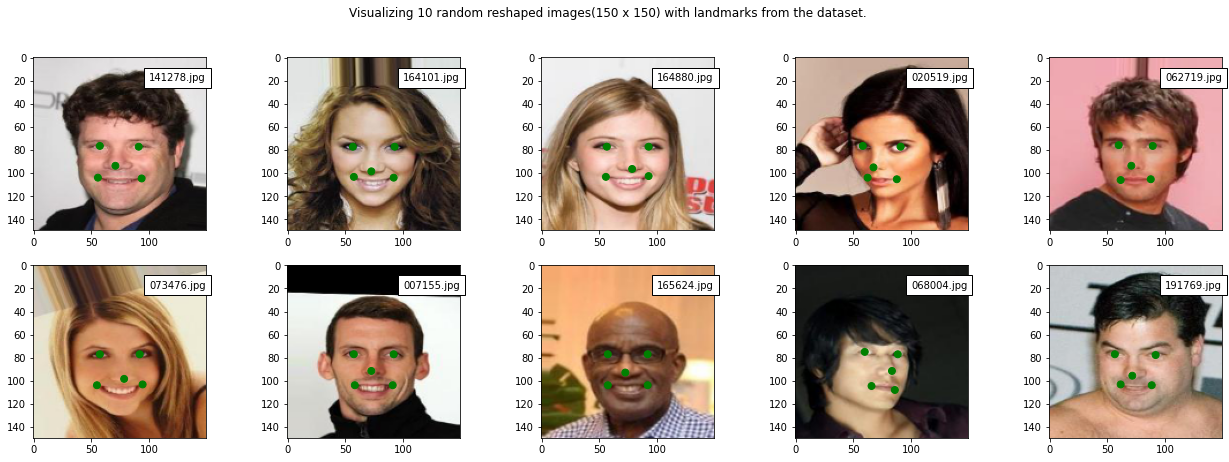

In [8]:
fig,axes = plt.subplots(2,5,figsize=(22,7))
imgPath = [os.path.join(path,img) for img in np.random.choice(os.listdir(path), size=10)]
for i,pth in enumerate(imgPath):
    img = image.load_img(pth)
    height,width = img_to_array(img).shape[0],img_to_array(img).shape[1]
    img = img_to_array(img)
    img = tf.image.resize(img,(150,150))
    img = array_to_img(img)
    jpg = pth.split('/')[-1]
    leftEyeX,leftEyeY = Lmark.loc[Lmark['image_id']==jpg,'lefteye_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'lefteye_y'].values[0]/height
    rightEyeX,rightEyeY = Lmark.loc[Lmark['image_id']==jpg,'righteye_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'righteye_y'].values[0]/height
    leftMouthX,leftMouthY = Lmark.loc[Lmark['image_id']==jpg,'leftmouth_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'leftmouth_y'].values[0]/height
    rightMouthX,rightMouthY = Lmark.loc[Lmark['image_id']==jpg,'rightmouth_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'rightmouth_y'].values[0]/height
    noseX,noseY = Lmark.loc[Lmark['image_id']==jpg,'nose_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'nose_y'].values[0]/height
    axes[i//5][i%5].imshow(img)
    axes[i//5][i%5].text(100, 20, f'{jpg}', bbox={'facecolor': 'white', 'pad': 5})
    leyecc,reyecc,lmouthcc,rmouthcc,nosecc = plt.Circle((leftEyeX*150,leftEyeY*150),3,color='green'),plt.Circle((rightEyeX*150,rightEyeY*150),3,color='green'),\
                    plt.Circle((leftMouthX*150,leftMouthY*150),3,color='green'),plt.Circle((rightMouthX*150,rightMouthY*150),3,color='green'),\
                    plt.Circle((noseX*150,noseY*150),3,color='green')
    axes[i//5][i%5].add_artist(leyecc)
    axes[i//5][i%5].add_artist(reyecc)
    axes[i//5][i%5].add_artist(lmouthcc)
    axes[i//5][i%5].add_artist(rmouthcc) 
    axes[i//5][i%5].add_artist(nosecc) 
fig.suptitle("Visualizing 10 random reshaped images(150 x 150) with landmarks from the dataset.")
fig.show()

In [9]:
try:
    os.mkdir('./img_align_celeba')
    os.mkdir(os.path.join('./img_align_celeba','train'))
    os.mkdir(os.path.join('./img_align_celeba','validate'))
    os.mkdir(os.path.join('./img_align_celeba','test'))
except OSError as error:
    print(error)

In [10]:
train,val,test = np.random.choice(df[df['Male']==1].loc[:162770,'image_id'],size=25000),\
                 np.random.choice(df[df['Male'] == 1].loc[162770:182637,'image_id'],size=10000),\
                 np.random.choice(df[df['Male'] == 1].loc[182637:202599,'image_id'],size=10000)

In [11]:
def createDataset(src,des,data,size):
    for imgFile in data:
        img = os.path.join(path,imgFile)
        try:
            i=image.load_img(img)
            copy(img,os.path.join(des,imgFile))
            if len(os.listdir(des)) == size:
                break
        except Exception as e:
            print(e)
    print(f'{len(os.listdir(des))} images copied successfully...')

In [12]:
t = time.process_time()
print('Creating dataset...')
createDataset(path,'./img_align_celeba/train',train,20000)
createDataset(path,'./img_align_celeba/validate',val,5000)
createDataset(path,'./img_align_celeba/test',test,5000)
train,val,test = os.listdir('./img_align_celeba/train'),os.listdir('./img_align_celeba/validate'),os.listdir('./img_align_celeba/test')
elaspedTime = time.process_time() - t
print(f'Dataset created! - Time takes: {elaspedTime}')

Creating dataset...
20000 images copied successfully...
5000 images copied successfully...
5000 images copied successfully...
Dataset created! - Time takes: 172.131897553


In [13]:
print(f'size of train: {len(train)}, val: {len(val)}, test: {len(test)}')

size of train: 20000, val: 5000, test: 5000


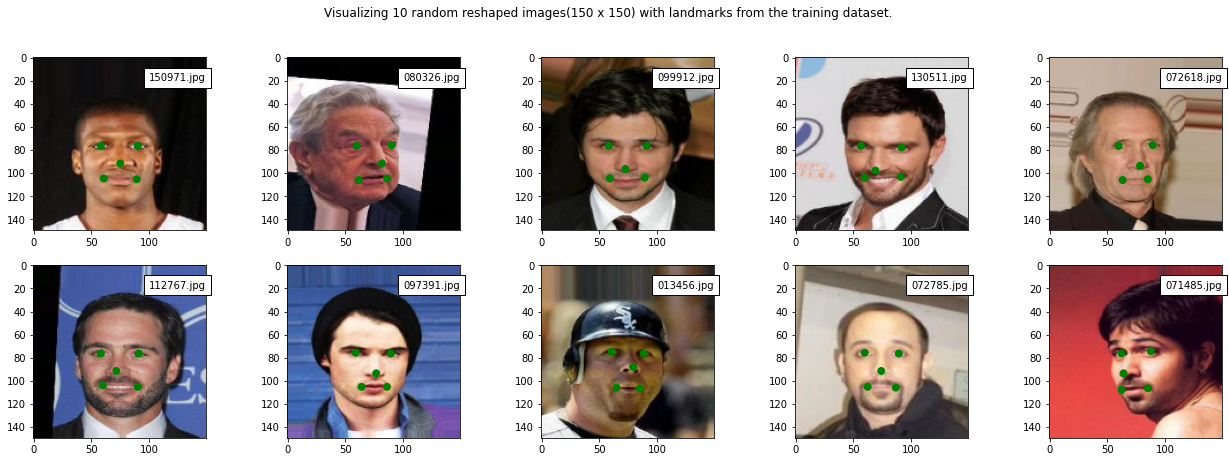

In [14]:
fig,axes = plt.subplots(2,5,figsize=(22,7))
imgPath = [os.path.join('./img_align_celeba/train',img) for img in np.random.choice(os.listdir('./img_align_celeba/train'), size=10)]
for i,pth in enumerate(imgPath):
    img = image.load_img(pth)
    height,width = img_to_array(img).shape[0],img_to_array(img).shape[1]
    img = img_to_array(img)
    img = tf.image.resize(img,(150,150))
    img = array_to_img(img)
    jpg = pth.split('/')[-1]
    leftEyeX,leftEyeY = Lmark.loc[Lmark['image_id']==jpg,'lefteye_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'lefteye_y'].values[0]/height
    rightEyeX,rightEyeY = Lmark.loc[Lmark['image_id']==jpg,'righteye_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'righteye_y'].values[0]/height
    leftMouthX,leftMouthY = Lmark.loc[Lmark['image_id']==jpg,'leftmouth_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'leftmouth_y'].values[0]/height
    rightMouthX,rightMouthY = Lmark.loc[Lmark['image_id']==jpg,'rightmouth_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'rightmouth_y'].values[0]/height
    noseX,noseY = Lmark.loc[Lmark['image_id']==jpg,'nose_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'nose_y'].values[0]/height
    axes[i//5][i%5].imshow(img)
    axes[i//5][i%5].text(100, 20, f'{jpg}', bbox={'facecolor': 'white', 'pad': 5})
    leyecc,reyecc,lmouthcc,rmouthcc,nosecc = plt.Circle((leftEyeX*150,leftEyeY*150),3,color='green'),plt.Circle((rightEyeX*150,rightEyeY*150),3,color='green'),\
                    plt.Circle((leftMouthX*150,leftMouthY*150),3,color='green'),plt.Circle((rightMouthX*150,rightMouthY*150),3,color='green'),\
                    plt.Circle((noseX*150,noseY*150),3,color='green')
    axes[i//5][i%5].add_artist(leyecc)
    axes[i//5][i%5].add_artist(reyecc)
    axes[i//5][i%5].add_artist(lmouthcc)
    axes[i//5][i%5].add_artist(rmouthcc) 
    axes[i//5][i%5].add_artist(nosecc) 
fig.suptitle("Visualizing 10 random reshaped images(150 x 150) with landmarks from the training dataset.")
fig.show()

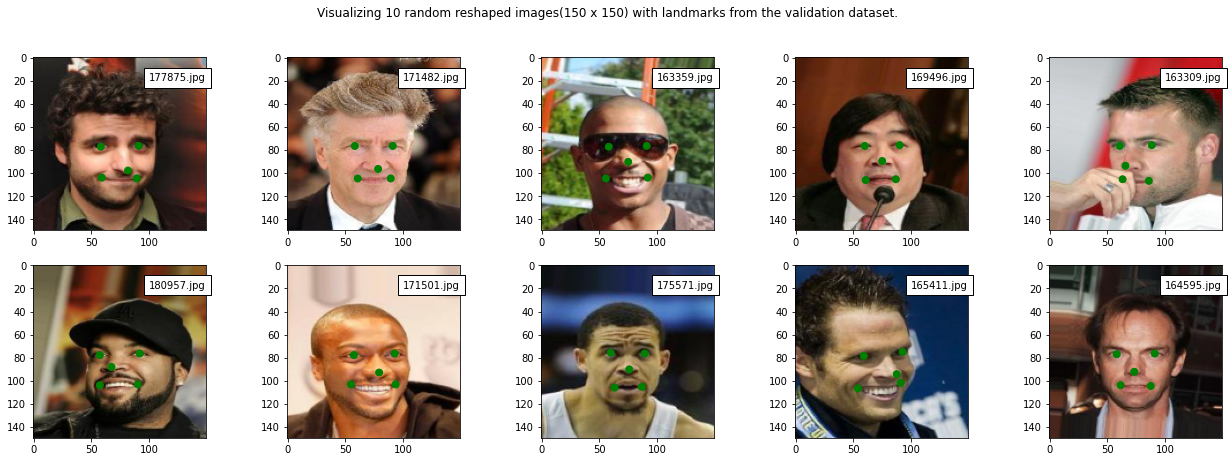

In [15]:
fig,axes = plt.subplots(2,5,figsize=(22,7))
imgPath = [os.path.join('./img_align_celeba/validate',img) for img in np.random.choice(os.listdir('./img_align_celeba/validate'), size=10)]
for i,pth in enumerate(imgPath):
    img = image.load_img(pth)
    height,width = img_to_array(img).shape[0],img_to_array(img).shape[1]
    img = img_to_array(img)
    img = tf.image.resize(img,(150,150))
    img = array_to_img(img)
    jpg = pth.split('/')[-1]
    leftEyeX,leftEyeY = Lmark.loc[Lmark['image_id']==jpg,'lefteye_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'lefteye_y'].values[0]/height
    rightEyeX,rightEyeY = Lmark.loc[Lmark['image_id']==jpg,'righteye_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'righteye_y'].values[0]/height
    leftMouthX,leftMouthY = Lmark.loc[Lmark['image_id']==jpg,'leftmouth_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'leftmouth_y'].values[0]/height
    rightMouthX,rightMouthY = Lmark.loc[Lmark['image_id']==jpg,'rightmouth_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'rightmouth_y'].values[0]/height
    noseX,noseY = Lmark.loc[Lmark['image_id']==jpg,'nose_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'nose_y'].values[0]/height
    axes[i//5][i%5].imshow(img)
    axes[i//5][i%5].text(100, 20, f'{jpg}', bbox={'facecolor': 'white', 'pad': 5})
    leyecc,reyecc,lmouthcc,rmouthcc,nosecc = plt.Circle((leftEyeX*150,leftEyeY*150),3,color='green'),plt.Circle((rightEyeX*150,rightEyeY*150),3,color='green'),\
                    plt.Circle((leftMouthX*150,leftMouthY*150),3,color='green'),plt.Circle((rightMouthX*150,rightMouthY*150),3,color='green'),\
                    plt.Circle((noseX*150,noseY*150),3,color='green')
    axes[i//5][i%5].add_artist(leyecc)
    axes[i//5][i%5].add_artist(reyecc)
    axes[i//5][i%5].add_artist(lmouthcc)
    axes[i//5][i%5].add_artist(rmouthcc) 
    axes[i//5][i%5].add_artist(nosecc) 
fig.suptitle("Visualizing 10 random reshaped images(150 x 150) with landmarks from the validation dataset.")
fig.show()

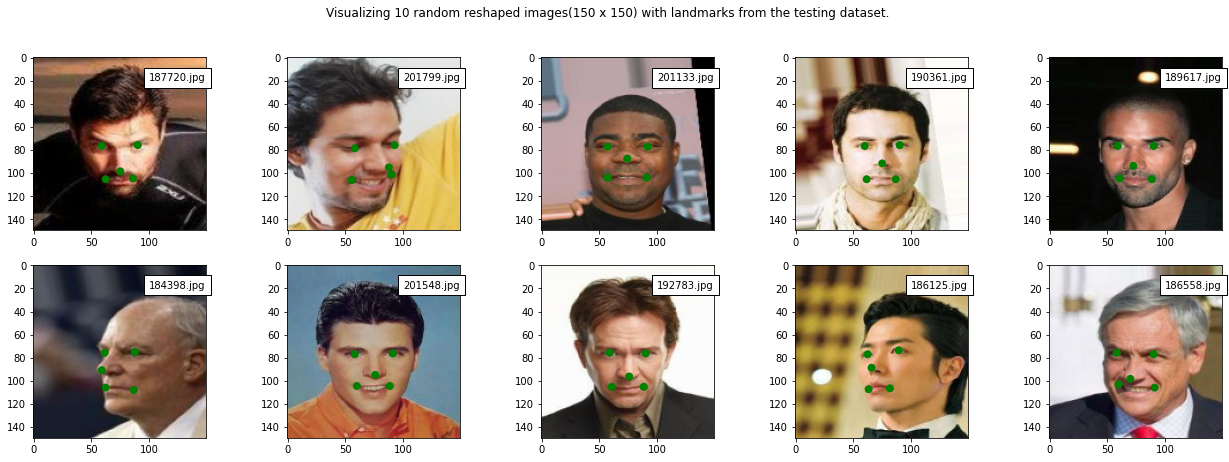

In [16]:
fig,axes = plt.subplots(2,5,figsize=(22,7))
imgPath = [os.path.join('./img_align_celeba/test',img) for img in np.random.choice(os.listdir('./img_align_celeba/test'), size=10)]
for i,pth in enumerate(imgPath):
    img = image.load_img(pth)
    height,width = img_to_array(img).shape[0],img_to_array(img).shape[1]
    img = img_to_array(img)
    img = tf.image.resize(img,(150,150))
    img = array_to_img(img)
    jpg = pth.split('/')[-1]
    leftEyeX,leftEyeY = Lmark.loc[Lmark['image_id']==jpg,'lefteye_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'lefteye_y'].values[0]/height
    rightEyeX,rightEyeY = Lmark.loc[Lmark['image_id']==jpg,'righteye_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'righteye_y'].values[0]/height
    leftMouthX,leftMouthY = Lmark.loc[Lmark['image_id']==jpg,'leftmouth_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'leftmouth_y'].values[0]/height
    rightMouthX,rightMouthY = Lmark.loc[Lmark['image_id']==jpg,'rightmouth_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'rightmouth_y'].values[0]/height
    noseX,noseY = Lmark.loc[Lmark['image_id']==jpg,'nose_x'].values[0]/width, Lmark.loc[Lmark['image_id']==jpg,'nose_y'].values[0]/height
    axes[i//5][i%5].imshow(img)
    axes[i//5][i%5].text(100, 20, f'{jpg}', bbox={'facecolor': 'white', 'pad': 5})
    leyecc,reyecc,lmouthcc,rmouthcc,nosecc = plt.Circle((leftEyeX*150,leftEyeY*150),3,color='green'),plt.Circle((rightEyeX*150,rightEyeY*150),3,color='green'),\
                    plt.Circle((leftMouthX*150,leftMouthY*150),3,color='green'),plt.Circle((rightMouthX*150,rightMouthY*150),3,color='green'),\
                    plt.Circle((noseX*150,noseY*150),3,color='green')
    axes[i//5][i%5].add_artist(leyecc)
    axes[i//5][i%5].add_artist(reyecc)
    axes[i//5][i%5].add_artist(lmouthcc)
    axes[i//5][i%5].add_artist(rmouthcc) 
    axes[i//5][i%5].add_artist(nosecc) 
fig.suptitle("Visualizing 10 random reshaped images(150 x 150) with landmarks from the testing dataset.")
fig.show()

In [17]:
yTrain,yVal,yTest = Lmark[Lmark['image_id'].isin(train)],\
                    Lmark[Lmark['image_id'].isin(val)],\
                    Lmark[Lmark['image_id'].isin(test)]
yTrain.loc[:,['lefteye_x','righteye_x','nose_x','leftmouth_x','rightmouth_x']] = (yTrain[['lefteye_x','righteye_x','nose_x','leftmouth_x','rightmouth_x']]*150//178).values
yTrain.loc[:,['lefteye_y','righteye_y','nose_y','leftmouth_y','rightmouth_y']] = (yTrain[['lefteye_y','righteye_y','nose_y','leftmouth_y','rightmouth_y']]*150//218).values
yVal.loc[:,['lefteye_x','righteye_x','nose_x','leftmouth_x','rightmouth_x']] = (yVal[['lefteye_x','righteye_x','nose_x','leftmouth_x','rightmouth_x']]*150//178).values
yVal.loc[:,['lefteye_y','righteye_y','nose_y','leftmouth_y','rightmouth_y']] = (yVal[['lefteye_y','righteye_y','nose_y','leftmouth_y','rightmouth_y']]*150//218).values
yTest.loc[:,['lefteye_x','righteye_x','nose_x','leftmouth_x','rightmouth_x']] = (yTest[['lefteye_x','righteye_x','nose_x','leftmouth_x','rightmouth_x']]*150//178).values
yTest.loc[:,['lefteye_y','righteye_y','nose_y','leftmouth_y','rightmouth_y']] = (yTest[['lefteye_y','righteye_y','nose_y','leftmouth_y','rightmouth_y']]*150//218).values

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [18]:
yTrain.shape, yVal.shape, yTest.shape

((20000, 11), (5000, 11), (5000, 11))

In [19]:
yTrain.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
12,000013.jpg,57,77,91,76,75,94,56,103,91,103
19,000020.jpg,58,77,91,75,72,86,60,104,86,103
22,000023.jpg,58,77,91,76,74,96,59,105,88,103
37,000038.jpg,58,77,91,76,78,94,57,103,91,104
47,000048.jpg,58,77,91,75,68,86,62,105,84,103


In [20]:
yVal.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
162771,162772.jpg,58,76,91,76,77,92,59,103,89,105
162773,162774.jpg,57,76,91,77,69,92,58,103,90,104
162777,162778.jpg,58,76,91,77,71,95,59,103,89,104
162778,162779.jpg,58,75,90,77,69,98,61,103,89,105
162782,162783.jpg,58,76,91,76,74,87,62,104,85,103


In [21]:
yTest.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
182642,182643.jpg,58,76,90,76,75,91,61,104,87,105
182648,182649.jpg,58,77,91,76,82,92,58,104,90,103
182651,182652.jpg,60,75,88,75,77,89,62,106,86,105
182652,182653.jpg,56,78,93,76,71,90,59,103,87,101
182661,182662.jpg,58,76,89,76,69,92,58,105,90,105


In [22]:
trainGenerator = IDG(
                    rescale=1/255.0
                   )
valGenerator = IDG(
                    rescale=1/255.0
                   )
testGenerator = IDG(
                    rescale=1/255.0
                   )

In [23]:
train = trainGenerator.flow_from_dataframe(dataframe=yTrain,directory='./img_align_celeba/train',\
                                           x_col='image_id',y_col=Lmark.columns[1:],class_mode='raw',\
                                           target_size=(150,150),batch_size=512)
val = valGenerator.flow_from_dataframe(dataframe=yVal,directory='./img_align_celeba/validate',\
                                           x_col='image_id',y_col=Lmark.columns[1:],class_mode='raw',\
                                           target_size=(150,150),batch_size=512)
test = testGenerator.flow_from_dataframe(dataframe=yTest,directory='./img_align_celeba/test',\
                                           x_col='image_id',y_col=Lmark.columns[1:],class_mode='raw',\
                                           target_size=(150,150),batch_size=512)

Found 20000 validated image filenames.
Found 5000 validated image filenames.
Found 5000 validated image filenames.


In [24]:
print('Creating Model...')
inputs = Input(shape=(150,150,3))
baseModel = InceptionV3(include_top=False,weights=None,input_shape=(150,150,3))
baseModel.trainable = True
x = baseModel(inputs,training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(10,activation='relu')(x)
model = Model(inputs=inputs,outputs=outputs)
print(f'Model created successfully...\n')
model.summary()

Creating Model...
Model created successfully...

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (D

In [25]:
callbacks = [ModelCheckpoint(filepath='weights.best.inc.male.hdf5',verbose=1,save_best_only=True),\
             EarlyStopping(monitor='val_loss',mode='min',patience=10,min_delta=1e1)]
print('Compiling model...')
model.compile(optimizer=RMSprop(),loss='mean_squared_error',metrics=['mae'])
print('Model compiled successfully!')
t = time.process_time()
print('Training started...')
history = model.fit(train,
                    validation_data=val,
                    epochs = 50,
                    callbacks = callbacks,
                    verbose = 1)
elaspedTime = time.process_time() - t
print(f'Model trained - Time Taken: {elaspedTime} sec')

Compiling model...
Model compiled successfully!
Training started...
Epoch 1/50
40/40 [==============================] - 69s 1s/step - loss: 1905.6540 - mae: 32.7162 - val_loss: 421.6153 - val_mae: 19.9449

Epoch 00001: val_loss improved from inf to 421.61530, saving model to weights.best.inc.male.hdf5
Epoch 2/50
40/40 [==============================] - 46s 1s/step - loss: 437.1831 - mae: 17.4006 - val_loss: 334.6819 - val_mae: 17.7650

Epoch 00002: val_loss improved from 421.61530 to 334.68195, saving model to weights.best.inc.male.hdf5
Epoch 3/50
40/40 [==============================] - 45s 1s/step - loss: 366.3652 - mae: 15.7437 - val_loss: 231.5888 - val_mae: 14.7593

Epoch 00003: val_loss improved from 334.68195 to 231.58881, saving model to weights.best.inc.male.hdf5
Epoch 4/50
40/40 [==============================] - 45s 1s/step - loss: 324.5497 - mae: 14.7797 - val_loss: 226.9077 - val_mae: 14.5762

Epoch 00004: val_loss improved from 231.58881 to 226.90765, saving model to weig

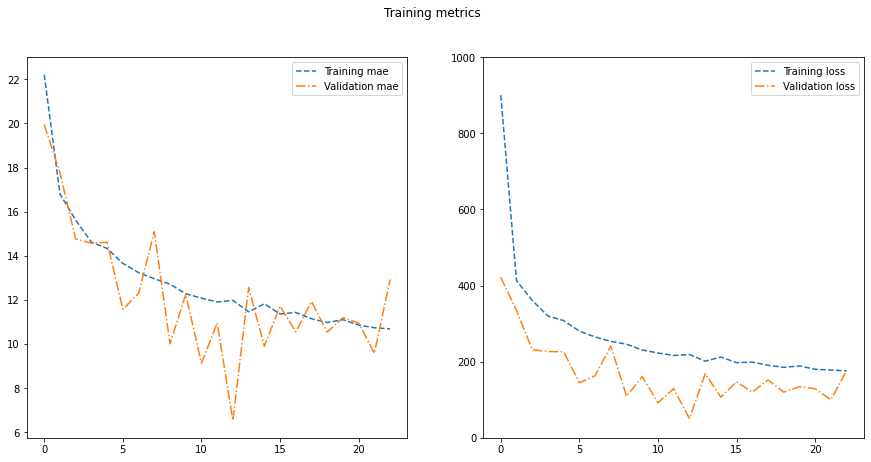

In [26]:
fig,axes = plt.subplots(1,2,figsize=(15,7))
acc = history.history['mae']
val_acc=history.history['val_mae']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs = range(len(acc))
sns.lineplot(x=epochs,y=acc,linestyle='--',ax=axes[0])
sns.lineplot(x=epochs,y=val_acc,linestyle='-.',ax=axes[0])
sns.lineplot(x=epochs,y=loss,linestyle='--',ax=axes[1])
sns.lineplot(x=epochs,y=val_loss,linestyle='-.',ax=axes[1])
axes[0].legend(['Training mae', 'Validation mae'])
axes[1].legend(['Training loss', 'Validation loss'])
axes[1].set_ylim([0, 1000])
fig.suptitle('Training metrics')
fig.show()

In [27]:
results = [model.evaluate(train, batch_size=512),model.evaluate(val, batch_size=512),model.evaluate(test, batch_size=512)]
print(f'Train: loss = {results[0][0]}, mae = {results[0][1]:.2f}')
print(f'Val: loss = {results[1][0]}, mae = {results[1][1]:.2f}')
print(f'Test: loss = {results[2][0]}, mae = {results[2][1]:.2f}')

10/10 [==============================] - 8s 732ms/step - loss: 176.1395 - mae: 12.8838
Train: loss = 177.08432006835938, mae = 12.92
Val: loss = 177.28358459472656, mae = 12.93
Test: loss = 176.1395263671875, mae = 12.88


In [28]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
yTrainPred,yValPred,yTestPred = model.predict(train,batch_size=512),model.predict(val,batch_size=512),model.predict(test,batch_size=512)
print(f'Train: mape = {mape(yTrain[yTrain.columns[1:]],yTrainPred):.2f}%')
print(f'Train: mape = {mape(yVal[yVal.columns[1:]],yValPred):.2f}%')
print(f'Train: mape = {mape(yTest[yTest.columns[1:]],yTestPred):.2f}%')

Train: mape = 15.70%
Train: mape = 15.71%
Train: mape = 15.66%


In [30]:
print(f'Train: accuracy = {100-mape(yTrain[yTrain.columns[1:]],yTrainPred):.2f}%')
print(f'Train: accuracy = {100-mape(yVal[yVal.columns[1:]],yValPred):.2f}%')
print(f'Train: accuracy = {100-mape(yTest[yTest.columns[1:]],yTestPred):.2f}%')

Train: accuracy = 84.30%
Train: accuracy = 84.29%
Train: accuracy = 84.34%


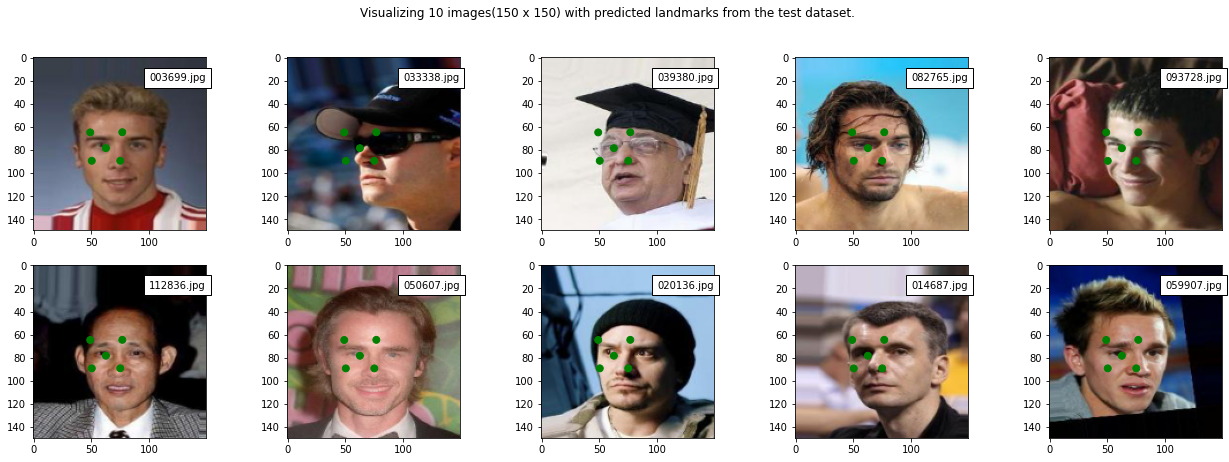

In [31]:
fig, axes = plt.subplots(2,5,figsize=(22,7))
testpath = './img_align_celeba/train'
dataGen = IDG(rescale=1/255.0)
for i,jpg in enumerate(np.random.choice(os.listdir(testpath), size=10)):
    img = image.load_img(os.path.join(testpath,jpg))
    img = img_to_array(img)
    img = img.reshape((1,)+img.shape)
    img = tf.image.resize(img,(150,150))
    label = model.predict(img)[0]
    img = array_to_img(img[0])
    axes[i//5][i%5].imshow(img)
    axes[i//5][i%5].text(100, 20, f'{jpg}', bbox={'facecolor': 'white', 'pad': 5})
    leyecc,reyecc,nosecc,lmouthcc,rmouthcc = plt.Circle((label[0],label[1]),3,color='green'),\
                    plt.Circle((label[2],label[3]),3,color='green'),\
                    plt.Circle((label[4],label[5]),3,color='green'),\
                    plt.Circle((label[6],label[7]),3,color='green'),\
                    plt.Circle((label[8],label[9]),3,color='green')
    axes[i//5][i%5].add_artist(leyecc)
    axes[i//5][i%5].add_artist(reyecc)
    axes[i//5][i%5].add_artist(lmouthcc)
    axes[i//5][i%5].add_artist(rmouthcc) 
    axes[i//5][i%5].add_artist(nosecc) 
fig.suptitle("Visualizing 10 images(150 x 150) with predicted landmarks from the test dataset.")
fig.show()